# Derivativos de Taxa de Juros
## Modelo de Kalotay-Williams-Fabozzi

Renato Mori, Uirá Caiado. 19 de Junho, 2016

**Resumo**

*Neste projeto vamos implementar um modelo de um fator chamado [Kalotay-Williams-Fabozzi](https://en.wikipedia.org/wiki/Short-rate_model#One-factor_short-rate_models), onde apenas um único fator estocástico - a taxa de juros instantânea - determina a evolução de toda estrutura a termo da taxa de juros. Vamos descrever brevemente o modelo, detalhar sua implementação, estimar seus parâmetros e demonstrar sua utilização para precificação de alguns títulos que sejam possíveis de compara com preços de mercado.*

## 1. Introdução

Nesta sessão vamos introduzir o modelo discutido neste trabalho e descrever o problema que será abordado aqui.


### 1.1. Modelagem da Curva de Juros

Como colocado por Fabozzi, a Taxa de Juros frequentemente é modelada usando equações diferenciais estocásticas([SDEs](https://en.wikipedia.org/wiki/Stochastic_differential_equation) é a abreviação em inglês). Os modelos mais comumente utilizados são os modelos de um ou dois fatores (estocástios), sendo que o de um usa uma SDE para representar a taxa de juros de curto prazo e a segunda representa tanto a taxa de curto como a de longo prazo. Na dinâmica escolhida para o modelo que deve ser refletidas as características desejadas para a curva, como reversão a média e volatilidade dependente do nível da taxa.

Existe duas abordagens para na utilizaçtão de equações estocásticas na modelagem da curva a termo de juros: modelos de equilibrio e modelos de não arbitragem, sendo que ambos são usados para precificar *Bonds* e derivativos sobre taxa de juros.

Modelos de equilíbrio começam com uma SDE e desenvolvem uma estrutura que não necessariamente correspondem aos preços observados no mercado. Alguns exemplos de modelos desta classe são o Vasicek, Brenna and Schwartz e o Cox, Ingersoll and Ross.

Os modelos de não arbitragem também utilizam uma SDE, porém usam os preços de mercado para gerar os caminhos possíveis para taxa de juros. Esta estrutura segue as características impostas pela SDE as taxas de juros encontradas, quando usadas para precificar um bond qualquer, resultam na mesma taxa de juros observada no mercado. Exemplos são o Ho and Lee, Black, Derman and Toy e o Hull and White.

Os modelos de não arbitragem geralmente são escolhidos para precificação de Bonds e derivativos pois garantem que as taxas atuais correspondam ao mercado. Este trabalgho explorará um modelo de não arbitragem chamado Kalotay-Williams-Fabozzi.

### 1.2. Modelo Kalotay-Williams-Fabozzi

O modelo Kalotay-Williams-Fabozzi (KWF) assume que as mudanças na taxa de juros de curto prazo segue um certo [processo estocástico](https://en.wikipedia.org/wiki/Stochastic_process) que pode ser descrito pela seguinte SDE:

$$ \mathrm{d} \ln(r) = \theta(t) \mathrm{d} t + \sigma\mathrm{d}Z$$

Onde $Z$ é um processo de [Wiener](https://en.wikipedia.org/wiki/Wiener_process), $\theta$ é o *drift* do processo e $\sigma$ é a volatilidade da primeira diferença das taxas de curto prazo.  Como o que a equação descreve é a dinâmica do **logarítimo natural** de taxa $r$ e $W$ tem distribuição normal, o $\ln(r)$ terá distribuição normal e o $r$, log normal. Desta maneira, embora $\ln(r)$ possa assumir valores negativos, $r$ não assumirá.

No trabalho original em que o modelo KWF foi apresentado, os autores não incluiram explicitamente o *drift* na dinâmica do processo e, por tanto, também não utilizaremos ele aqui,

## 2. Implementando o Modelo

Nesta sessão detalharemos e implementaremos o modelo utilizando como referência o artigo original e calibraremos ele para que bata com os dados de mercado.

### 2.1. Aproximação da SDE por Árvore Binomial

As equações diferenciais estocásticas podem ter sua solução aproximada numericamente utilizando uma árvore binomial. Este método assume que a taxa de juros de curto prazo pode assumir apenas dois valores no período seguinte da discretização, $r_{u}$ ou $r_{d}$, onde $r_{u} > r_{d}$. Como cada nó da árvore dá origem à dois novos nós, a medida que se aumenta os passos de discretização, o número de nós rapidamente aumenta. Para evitar este crescimento exponencial, é imposto ao modelo que a árvore seja recombinante, ou seja, um movimento de subida seguido por uma queda resulta no mesmo nó de uma queda seguida de uma alta. 

Um movimento de alta na taxa de juros tem probabilidade $q$ de ocorrer, enquanto um de queda tem probabilidade de $1 - q$. Utilizaremos probabilidade de $q=0.5$ para garantir a netralidade a risco na solução da SDE. É importante frisar que isso não implica na probabilidade real da taxa de juros cair. $q$ representa apenas a probabilidade *neutra a risco*. 

In [1]:
# bibliotecas necessarias
import numpy as np
import math
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

In [2]:
from collections import defaultdict

class DIFFERENT_SOURCES_ERROR(Exception):
    '''
    DIFFERENT_SOURCES_ERROR is raised when ...
    '''
    pass


class Node(object):
    '''
    A representation of a single Node in a binary tree
    '''
    def __init__(self, s_name, f_prob=0.5):
        '''
        Instatiate a Node object. Save all parameter as attributes
        :param s_name: string. The name of the node. Is expected
            to be composed just by 'D'(down) and 'U'(up)
        '''
        # conta a qtde de subidas e descidas para
        # organizacao de nos posteriormente
        i_d = s_name.count('D') * -1
        i_u = s_name.count('U')
        i_len = len(s_name)
        if s_name == '_':
            i_len = 0
        self.i_step = i_len
        self.i_level = i_d+i_u
        self.node_idx = '{},{}'.format(i_len, i_d+i_u)
        # guarda nome e inicia branch
        self.name = str(s_name)
        # inicia parametros do no
        self.f_r = None
        self.f_time = None
        self.f_cupon = None
        self.f_value = None
        self.f_prob = 0.5
    
    def set_values(f_r, f_time, f_cupon, f_value):
        '''
        Set values of the node
        '''
        self.f_r = f_r
        self.f_time = f_time
        self.f_cupon = f_cupon
        self.f_value = f_value
        
    def get_childrens(self):
        '''
        Return the possible childrens of the node
        '''
        s_name = self.name
        if self.name == '_':
            s_name = ''
        return s_name + 'D',  s_name + 'U'
    
    def get_source(self):
        '''
        Return the possible childrens of the node
        '''
        s_name = self.name
        if len(s_name) == 1 and s_name != '_':
            return '_'
        elif self.name == '_':
            s_name = ''
        else:
            return s_name[:-1]

    def __str__(self):
        '''
        Return the name of the node
        '''
        return self.name
    
    def __add__(self, other):
        '''
        Add Nodes. Return the value of the weighted sum
        of face values of the given nodes
        :param other: Object. A Node instace
        '''
        s_src = self.get_source()
        # para serem somados, os nodes preciosam ser iguais
        if other != other.get_source():
            raise DIFFERENT_SOURCES_ERROR
        # calcula valor
        f_value = self.f_value * self.f_prob
        f_value += other.f_value * other.f_prob
        
        return f_value

    def __repr__(self):
        '''
        Return the name of the node
        '''
        return self.name

    def __eq__(self, other):
        '''
        Return if a node has different node_idx from the other
        :param other: node object. Node to be compared
        '''
        if isinstance(other, str):
            i_aux = other.count('D')*-1 + other.count('U')
            i_len = len(other)
            if s_name == '_':
                i_len = 0
            s_aux = '{},{}'.format(i_len, i_aux)
            return self.node_idx == s_aux
        return self.node_idx == other.node_idx

    def __ne__(self, other):
        '''
        Return if a node has the same node_idx from the other
        :param other: node object. Node to be compared
        '''
        return not self.__eq__(other)

    def __hash__(self):
        '''
        Allow the node object be used as a key in a hash
        table
        '''
        return self.node_idx.__hash__()


class BinomialTree(object):
    '''
    A representation of a Binomial Tree
    '''
    def __init__(self, i_steps):
        '''
        Initiate a BinomialTree object. Save all parameter as
        attributes
        :param i_step: integer. Number of steps in the tree
        '''
        # python sets se comportam como hastable. O tempo
        # de procura eh O(1), e nao O(n) como uma lista
        self.set_of_nodes = set([])
        # inicia outras variaveis
        self.i_steps = i_steps
        self.d_step = defaultdict(list)
        self.d_level = defaultdict(list)
        # insere nodes
        node_root = Node('_')
        self.d_level[0] = [node_root]
        self.d_step[0] = [node_root]
        self.set_of_nodes.add(node_root)
        # constroi arvore
        self.set_branchs(i_steps)

    def set_branchs(self, i_steps):
        '''
        Create all the brachs of the binomial tree using the
        first node as root
        :param i_step: integer. Number of steps in the tree
        '''
        # constroi arvore
        for i_step in xrange(1, i_steps):
            for node in self.d_step[i_step-1]:
                s_down, s_up = node.get_childrens()
                self.add_node(i_step, s_down)
                self.add_node(i_step, s_up)

    def add_node(self, i_step, s_name):
        '''
        Include a new node in the tree. To reduce the number
        of nodes, a restriction called recombination condition
        is imposed on the algorithm. This make the binomial
        method more computationally tractable since the number
        of nodes at each step increases by only one node
        :param i_step: integer.
        :param s_name: string.
        '''
        node = Node(s_name)
        if node not in self.set_of_nodes:
            self.set_of_nodes.add(node)
            self.d_step[node.i_step].append(node)
            self.d_level[node.i_level].append(node)

    def __str__(self):
        '''
        Return ascii representation of the binomial tree,
        imposing a limite of 8 nodes to be printed out
        '''
        # limita passos plotados
        i_steps = min(8, self.i_steps)
        # itera dicionario de niveis e insere em string tabulada
        d_aux = {}
        for i_key in xrange(-1 * i_steps, i_steps + 1, 1):
            s_aux = ''
            for i_inner in xrange(0, i_steps + 1):
                valid_node = ''
                for node in self.d_level[i_key]:
                    if node.i_step == i_inner:
                        valid_node = node
                s_aux += '{}\t'.format(valid_node)
            d_aux[i_key] = s_aux[:-1] + '\n'
        # organiza chaves
        l = d_aux.keys()
        l.sort()
        # junta strings criadas em uma unica, de maneir aordenada
        s_rtn = ''
        for i_key in l:
            s_rtn += d_aux[i_key]
        if i_steps != self.i_steps:
            s_rtn += '\nPlotted {} from {} steps'.format(i_steps, self.i_steps)
        return s_rtn

In [3]:
import time
import binomial_tree; reload(binomial_tree);

def foo(i):
    f_start = time.time()
    x = binomial_tree.BinomialTree(i)
    i_rtn = len(x.set_of_nodes)
    return i_rtn, time.time() - f_start

print "Tempo para inicar toda a arvore: "
for i in [10, 100, 250, 500, 1000]:
    # mais de 1000 nodes trava
    i_nodes, f_time = foo(i)
    print "- Com {} passos: Criados {:0,.0f} em {:.2f} segundos".format(i, i_nodes, f_time)

Tempo para inicar toda a arvore: 
- Com 10 passos: Criados 55 em 0.01 segundos
- Com 100 passos: Criados 5,050 em 0.08 segundos
- Com 250 passos: Criados 31,375 em 0.45 segundos
- Com 500 passos: Criados 125,250 em 1.97 segundos
- Com 1000 passos: Criados 500,500 em 8.87 segundos


In [4]:
import binomial_tree; reload(binomial_tree);
x = binomial_tree.BinomialTree(12)
print 'Primeiros passos da arvore criada:\n========================================\n\n'
print x

Primeiros passos da arvore criada:


								DDDDDDDD
							DDDDDDD	
						DDDDDD		DDDDDDDU
					DDDDD		DDDDDDU	
				DDDD		DDDDDU		DDDDDDUU
			DDD		DDDDU		DDDDDUU	
		DD		DDDU		DDDDUU		DDDDDUUU
	D		DDU		DDDUU		DDDDUUU	
_		DU		DDUU		DDDUUU		DDDDUUUU
	U		DUU		DDUUU		DDDUUUU	
		UU		DUUU		DDUUUU		DDDUUUUU
			UUU		DUUUU		DDUUUUU	
				UUUU		DUUUUU		DDUUUUUU
					UUUUU		DUUUUUU	
						UUUUUU		DUUUUUUU
							UUUUUUU	
								UUUUUUUU

Plotted 8 from 12 steps


In [84]:
class Node(object):
    '''
    A representation of a single Node in a binary tree
    '''
    def __init__(self, s_name, f_prob=0.5):
        '''
        Instatiate a Node object. Save all parameter as attributes
        :param s_name: string. The name of the node. Is expected
            to be composed just by 'D'(down) and 'U'(up)
        '''
        # conta a qtde de subidas e descidas para
        # organizacao de nos posteriormente
        i_d = s_name.count('D') * -1
        i_u = s_name.count('U')
        i_len = len(s_name)
        if s_name == '_':
            i_len = 0
        self.i_step = i_len
        self.i_level = i_d+i_u
        self.node_idx = '{},{}'.format(i_len, i_d+i_u)
        # guarda nome e inicia branch
        self.name = str(s_name)
        # inicia parametros do no
        self.f_r = 0.
        self.f_time = 0.
        self.f_cupon = 0.
        self.f_value = 0.
        self.f_prob = 0.5
    
    def set_values(self, f_cupon, f_value, f_r=None, f_time=None):
        '''
        Set values of the node
        '''
        if f_r:
            self.f_r = f_r
        if f_time:
            self.f_time = f_time
        self.f_cupon = f_cupon
        self.f_value = f_value
    
    def set_rate(self, f_value):
        '''
        '''
        self.f_r = f_r
        
    def get_childrens(self):
        '''
        Return the possible childrens of the node
        '''
        s_name = self.name
        if self.name == '_':
            s_name = ''
        return s_name + 'D',  s_name + 'U'
    
    def get_source(self):
        '''
        Return the possible childrens of the node
        '''
        s_name = self.name
        if len(s_name) == 1 and s_name != '_':
            return '_'
        elif self.name == '_':
            s_name = ''
        else:
            return s_name[:-1]

    def __str__(self):
        '''
        Return the name of the node
        '''
        return self.name
    
    def __add__(self, other):
        '''
        Add Nodes. Return the value of the weighted sum
        of face values of the given nodes
        :param other: Object. A Node instace
        '''
        s_src = self.get_source()
        # para serem somados, os nodes preciosam ser iguais
        if other != other.get_source():
            raise DIFFERENT_SOURCES_ERROR
        # calcula valor
        f_value = self.f_value * self.f_prob
        f_value += other.f_value * other.f_prob
        
        return f_value

    def __repr__(self):
        '''
        Return the name of the node
        '''
        return self.name

    def __eq__(self, other):
        '''
        Return if a node has different node_idx from the other
        :param other: node object. Node to be compared
        '''
        if isinstance(other, str):
            i_aux = other.count('D')*-1 + other.count('U')
            i_len = len(other)
            if s_name == '_':
                i_len = 0
            s_aux = '{},{}'.format(i_len, i_aux)
            return self.node_idx == s_aux
        return self.node_idx == other.node_idx

    def __ne__(self, other):
        '''
        Return if a node has the same node_idx from the other
        :param other: node object. Node to be compared
        '''
        return not self.__eq__(other)

    def __hash__(self):
        '''
        Allow the node object be used as a key in a hash
        table
        '''
        return self.node_idx.__hash__()

In [201]:
import math
from scipy import optimize

class DIFFERENT_SOURCES_ERROR(Exception):
    '''
    DIFFERENT_SOURCES_ERROR is raised when ...
    '''
    pass


class DIFFERENT_LENGTHS_ERROR(Exception):
    '''
    DIFFERENT_LENGTHS_ERROR is raised when ...
    '''
    pass


def kwf_sde(f_init_rate, f_sigma, i_above_min, f_time):
    '''
    Return the value of the short rate given by the dynamic
    given in the paper
    :param f_time: float. time to maturity
    :param i_above_min: integer.
    '''
    theta_dt = 0.
    sigma_w = f_sigma * (f_time**0.5) * (i_above_min * 1.)
    return f_init_rate * math.exp(sigma_w)


class KWFTree(object):
    '''
    A representation of a Binomial Tree
    '''
    def __init__(self, l_short_rates, l_maturities):
        '''
        Initiate a BinomialTree object. Save all parameter as
        attributes
        :param l_short_rates: list. The short rates to be fitted
        :param l_maturities: list. The maturities of the rates
        :param f_sigma: float. Dispersion of the short rate
        '''
        # checa se listas tem mesmo tamanho
        if len(l_short_rates) != len(l_maturities):
            raise DIFFERENT_LENGTHS_ERROR
        self.l_maturities = l_maturities
        self.l_short_rates = l_short_rates
        # python sets se comportam como hastable. O tempo
        # de procura eh O(1), e nao O(n) como uma lista
        self.set_of_nodes = set([])
        self.d_nodes = defaultdict(float)
        # inicia outras variaveis
        self.i_steps = len(l_short_rates)
        self.d_step = defaultdict(list)
        self.d_level = defaultdict(list)
        # insere nodes
        node_root = Node('_')
        node_root.set_values(f_r=l_short_rates[0],
                             f_time=l_maturities[0],
                             f_cupon=0,
                             f_value=None)
        self.d_level[0] = [node_root]
        self.d_step[0] = [node_root]
        self.set_of_nodes.add(node_root)
        self.d_nodes[node_root] = node_root
        # constroi arvore
        self.go_foward(self.i_steps)

    def fit_short_term_curve(self, func_rate, f_sigma, f_face_value=100.):
        '''
        :param func_rate
        :param f_sigma
        :*param f_face_value
        '''
        self.f_face_value = f_face_value
        self.f_sigma = f_sigma
        self.func_rate = func_rate
        for i_step in xrange(1, self.i_steps):
            self._go_backward(i_step)
    
    def _get_short_rate(self, f_init_rate, node):
        '''
        '''
        i_above_min = node.i_level - (node.i_step * -1)
        f_rtn = self.func_rate(f_init_rate, self.f_sigma, i_above_min, node.f_time)
        return f_rtn

    def _get_time_step(self, i_step):
        '''
        '''
        f_time = self.l_maturities[i_step]
        if i_step==0:
            f_time_0 = 0.
        else:
            f_time_0 = self.l_maturities[i_step-1]
        return f_time-f_time_0
    
    def go_foward(self, i_steps):
        '''
        Create all the brachs of the binomial tree using the
        first node as root
        :param i_step: integer. Number of steps in the tree
        '''
        # constroi arvore
        l_time = [0.] + self.l_maturities
        for i_step in xrange(1, i_steps+1):
            # cria nos do step
            for node in self.d_step[i_step-1]:
                f_time = l_time[i_step] - l_time[i_step-1]
                s_down, s_up = node.get_childrens()
                self.add_node(s_down, f_time)
                self.add_node(s_up, f_time)

    def _go_backward(self, i_step):
        '''
        Create all the brachs of the binomial tree using the
        first node as root
        :param i_step: integer. Number of steps in the tree
        '''
        # preenche valores no passo posterior
        f_initial_rate = self.l_short_rates[i_step]
        f_face_value = self.f_face_value
        f_cupon = f_face_value * self.l_short_rates[i_step]
        for node in self.d_step[i_step+1]:
            node.set_values(f_cupon=f_cupon,
                            f_value=f_face_value)
        # itera taxas para fazer root ficar com valor de zero
        # TODO: aqui que preciso iterar
        res = optimize.minimize(self._set_all_values, f_initial_rate, args=(f_cupon, i_step))
    
    
    def _set_all_values(self, f_rate, f_cupon, i_step):
        '''
        ...
        :param i_step: integer. Step to start iteration.
        '''
        # preenche taxas do passo atual
        for node in self.d_step[i_step]:
            node.f_r = self._get_short_rate(f_rate, node)
        # itera toda a arvore. Eh esperado que nos anteriores jah
        # tenham a taxa setada
        for i_aux_step in xrange(i_step, -1, -1):
            for node in self.d_step[i_aux_step]:
                s_down, s_up = node.get_childrens()
                node_down = self[s_down]
                node_up = self[s_up]
                f_aux = (node_down.f_value + f_cupon) * node.f_prob
                f_aux += (node_up.f_value + f_cupon) * node.f_prob
                f_aux /= (1+node.f_r)**(node_down.f_time)
                node.set_values(f_cupon=f_cupon,
                                f_value=f_aux)
        return (self["_"].f_value - self.f_face_value)**2
    
    def add_node(self, s_name, f_time):
        '''
        Include a new node in the tree. To reduce the number
        of nodes, a restriction called recombination condition
        is imposed on the algorithm. This make the binomial
        method more computationally tractable since the number
        of nodes at each step increases by only one node
        :param s_name: string.
        :param f_time: float.
        '''
        node = Node(s_name)
        if node not in self.set_of_nodes:
            node.f_time = f_time
            self.set_of_nodes.add(node)
            self.d_nodes[node] = node
            self.d_step[node.i_step].append(node)
            self.d_level[node.i_level].append(node)

    def __getitem__(self, s_idx):
        '''
        Allow direct access to the nodes of the object
        '''
        if isinstance(s_idx, str):
            s_idx = Node(s_idx)
        return self.d_nodes[s_idx]

    def __str__(self):
        '''
        Return ascii representation of the binomial tree,
        imposing a limite of 8 nodes to be printed out
        '''
        # limita passos plotados
        i_steps = min(8, self.i_steps)
        # itera dicionario de niveis e insere em string tabulada
        d_aux = {}
        for i_key in xrange(-1 * i_steps, i_steps + 1, 1):
            s_aux = ''
            for i_inner in xrange(0, i_steps + 1):
                valid_node = ''
                for node in self.d_level[i_key]:
                    if node.i_step == i_inner:
                        valid_node = node
                s_aux += '{}\t'.format(valid_node)
            d_aux[i_key] = s_aux[:-1] + '\n'
        # organiza chaves
        l = d_aux.keys()
        l.sort()
        # junta strings criadas em uma unica, de maneir aordenada
        s_rtn = ''
        for i_key in l:
            s_rtn += d_aux[i_key]
        if i_steps != self.i_steps:
            s_rtn += '\nPlotted {} from {} steps'.format(i_steps, self.i_steps)
        return s_rtn

In [325]:
import binomial_tree; reload(binomial_tree);
x = binomial_tree.BinomialTree(3)
x._go_foward(x.i_steps)
print 'Primeiros passos da arvore criada:\n========================================\n'
print x

Primeiros passos da arvore criada:

			
		DD	
	D		
_		DU	
	U		
		UU	
			



In [397]:
import binomial_tree; reload(binomial_tree);
x = binomial_tree.KWFTree([0.035, 0.04, 0.045], [1., 2., 3.])
print 'Primeiros passos da arvore criada:\n========================================\n'
print x

Primeiros passos da arvore criada:

			DDD
		DD	
	D		DDU
_		DU	
	U		DUU
		UU	
			UUU



In [398]:
x.fit_foward_curve(0.1)

In [399]:
df = x.get_lattice()

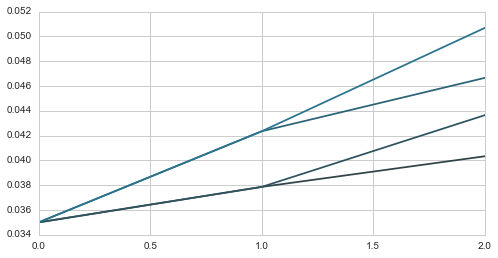

In [400]:
df.plot(legend=False)

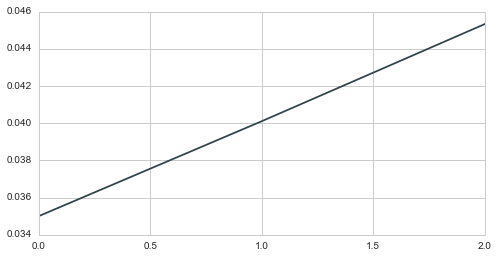

In [404]:
df.T.mean().plot()

In [355]:
import numpy as np

In [359]:
list(np.arange(0.035, 0.1))

[0.035000000000000003]

In [385]:
def foo():
    l_rates = list(np.linspace(0.035, 0.12, 100))
    l_mat = list(np.arange(1., len(l_rates)+1))
    x = binomial_tree.KWFTree(l_rates, l_mat)
    x.fit_foward_curve(0.1)
    df = x.get_lattice()
    return df

%time df = foo()

CPU times: user 36.4 s, sys: 187 ms, total: 36.6 s
Wall time: 36.6 s


In [389]:
df.tail()

,0,1,2,3,4,5,6,7,8,9,...,188,189,190,191,192,193,194,195,196,197
95,0.147789,0.147789,0.147789,0.147789,0.147789,0.147789,0.147789,0.147789,0.148062,0.148062,...,712.019198,712.019198,831.302867,831.302867,971.339544,971.339544,1136.247253,1136.247253,1330.964444,1330.964444
96,0.147472,0.147472,0.147472,0.147472,0.147472,0.147472,0.147744,0.147744,0.148338,0.148338,...,786.914906,786.914906,919.157896,919.157896,1074.469540,1074.469540,1257.430117,1257.430117,1473.533642,1473.533642
97,0.147170,0.147170,0.147170,0.147170,0.147441,0.147441,0.148033,0.148033,0.149005,0.149005,...,869.744506,869.744506,1016.354983,1016.354983,1188.606718,1188.606718,1391.593865,1391.593865,inf,inf
98,0.146883,0.146883,0.147153,0.147153,0.147743,0.147743,0.148711,0.148711,0.150123,0.150123,...,961.352682,961.352682,1123.891805,1123.891805,inf,inf,inf,inf,inf,inf
99,0.146611,0.146880,0.147148,0.147468,0.148052,0.148431,0.149390,0.149838,0.151237,0.151763,...,1060.549118,1062.674340,inf,inf,inf,inf,inf,inf,inf,inf


In [396]:
df.tail(1).T.tail(15)

,99
183,660.575320
184,774.974345
185,776.527847
186,906.993742
187,908.811547
188,1060.549118
189,1062.674340
190,inf
191,inf
192,inf


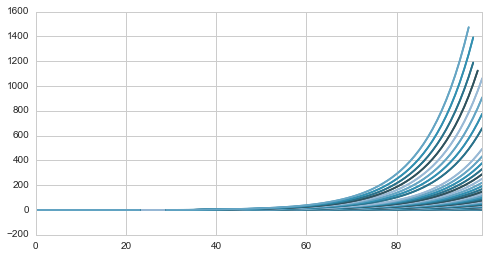

In [387]:
df.plot(legend=False)

In [388]:
df.shape

(100, 198)

In [267]:
l_nodes = []
for node in x.d_step[x.i_steps-2]:
    s_d, s_u = node.get_childrens()
    l_nodes.append(x[s_d])
    l_nodes.append(x[s_u])

In [268]:
l_nodes

[DDDD, DDDU, DDDU, DDUU, DDUU, DUUU, DUUU, UUUU]

In [323]:
self[s_d]

DU

In [328]:
self = x


d_rtn = {}
# cria ultimos nos sem recombinacao
l_nodes = []
for node in self.d_step[self.i_steps-2]:
    s_d, s_u = node.get_childrens()
    
    node_down = self[s_d].copy()
    node_down.name = s_d
    node_up = self[s_u].copy()
    node_up.name = s_u
    l_nodes.append(node_down)
    l_nodes.append(node_up)
# itera para recriar trelica
for idx, node in enumerate(l_nodes):
    s_name = node.name
    s_key = "{}_{}".format(idx, s_name)

    d_rtn[s_key] = []
    for idx in xrange(len(s_name)+1):
        d_rtn[s_key].append(float(self[s_name[:idx]].f_r))
        
# monta dataframe
df = pd.DataFrame(d_rtn).T
df = df + 1
df = df.cumprod(axis=1)
df = df.apply(lambda x: x**(1./(x.name+1))) - 1
df = df.T

In [314]:
import pandas as pd

In [331]:
df = pd.DataFrame(d_rtn).T
df = df + 1
df = df.cumprod(axis=1)
df = df.apply(lambda x: x**(1./(x.name+1))) - 1
df = df.T

In [329]:
df = pd.DataFrame(d_rtn).T

In [330]:
df

,0,1,2
0_DD,0.035,0.040736,0.045296
1_DU,0.035,0.040736,0.055325
2_UD,0.035,0.049755,0.055325
3_UU,0.035,0.049755,0.067574


In [318]:
df

,0,1,2
0_DD,0.035,0.037864,0.040335
1_DU,0.035,0.037864,0.043652
2_DU,0.035,0.037864,0.043652
3_UU,0.035,0.042351,0.050692


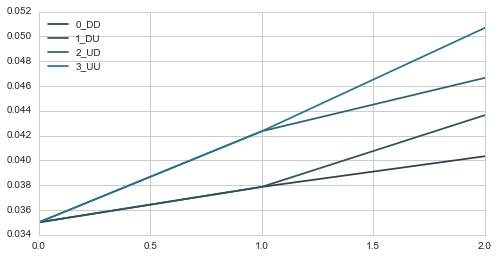

In [332]:
df.T.plot()

In [277]:
l_nodes

[DDDD, DDDU, DDDU, DDUU, DDUU, DUUU, DUUU, UUUU]

In [278]:
d_rtn.keys()

['UUUU', 'DUUU', 'DDDD', 'DDDU', 'DDUU']

In [322]:
print x['_'].f_r
print x['D'].f_r
print x['U'].f_r
print x['DD'].f_r
print x['UD'].f_r
print x['UU'].f_r

0.035
[ 0.04073606]
[ 0.04975513]
[ 0.04529594]
[ 0.05532458]
[ 0.0675736]


In [274]:
x.get_lattice()

{'DDDD': [0.035,
  0.04073605689199079,
  0.04529593659505166,
  0.04895437891365224,
  6644.9405767442],
 'DDDU': [0.035,
  0.04073605689199079,
  0.04529593659505166,
  0.04895437891365224,
  8116.148748245796],
 'DDUU': [0.035,
  0.04073605689199079,
  0.04529593659505166,
  0.0597930134291529,
  9913.086466745624],
 'DUUU': [0.035,
  0.04073605689199079,
  0.05532458189064427,
  0.07303135152107543,
  12107.87115236336],
 'UUUU': [0.035,
  0.04975513224444715,
  0.06757359691529109,
  0.08920069418000645,
  14788.587220944562]}

In [209]:
print x['_'].f_r
print x['D'].f_r

0.035
[ 0.04073606]


In [184]:
for i_aux_step in xrange(1, 0, -1):
    if i_aux_step==0:
        print "entrei aqui"

In [186]:
range(1, -1, -1)

[1, 0]

In [69]:
x.d_step[3][3].f_time

1.0

In [46]:
g.f_value

In [47]:
'D' * 3

'DDD'

In [31]:
y = x.d_nodes["_"]

In [34]:
type(y)

float

In [ ]:
def squared_error(l_par, l_T, l_yield):
    '''
    Return the squared error between the curve calculate by the NSS model and
    the real data
    :param l_par: list. parameters to be used to create the NSS model
    :param l_T: list. a ordered list of time in years of each foward rate
    :param l_yield: list. list of floats of the foward rates. ordered by l_T
    '''
    nss = NelsonSiegelSvensson(*l_par)
    return sum([(b-float(a)) ** 2 for a, b in zip(nss(l_T), l_yield)])

res = optimize.minimize(squared_error, l_par2, args=(l_T, l_yield))
nss = NelsonSiegelSvensson(*res.x)

In [148]:
class BinomialTreeOptimized(object):
    '''
    A representation of the Binomial Tree Optimized
    '''
    def __init__(self, i_steps):
        '''
        Initiate a BinomialTreeOptimized object. Save all parameter as
        attributes
        :param i_step: integer. Number of steps in the tree
        '''
        # python sets se comportam como hastable. O tempo
        # de procura eh O(1), e nao O(n) como uma lista
        self.set_of_nodes = set([])
        self.set_of_nodes_new = set([])
        # inicia outras variaveis
        self.i_steps = i_steps
        self.d_step = defaultdict(Node)
        # insere nodes
        node_root = Node('_')
        self.d_step[0] = [node_root]
        self.set_of_nodes.add(node_root)
        # constroi arvore
        self.set_foward(i_steps)

    def set_foward(self, i_steps):
        '''
        Create all the brachs of the binomial tree using the
        first node as root
        :param i_step: integer. Number of steps in the tree
        '''
        # constroi arvore
        for i_step in xrange(1, i_steps):
            self.set_of_nodes_new = set([])
            for node in self.set_of_nodes:
                s_down, s_up = node.get_childrens()
                self.add_node(s_down)
                self.add_node(s_up)
            self.set_of_nodes = self.set_of_nodes_new.copy()
            
    def set_backward(self):
        '''
        Create all the brachs of the binomial tree from
        the last step to the first
        '''
        # constroi arvore
        for i_step in xrange(len(self.set_of_nodes)-1, 0, -1):
            self.set_of_nodes_new = set([])
            for node in self.set_of_nodes:
                s_src= node.get_source()
                self.add_node(s_src)
            self.set_of_nodes = self.set_of_nodes_new.copy()

    def add_node(self, s_name):
        '''
        Include a new node in the tree. To reduce the number
        of nodes, a restriction called recombination condition
        is imposed on the algorithm. This make the binomial
        method more computationally tractable since the number
        of nodes at each step increases by only one node
        :param s_name: string.
        '''
        node = Node(s_name)
        if node not in self.set_of_nodes:
            self.set_of_nodes_new.add(node)
            if node.name.count('D') == node.i_step:
                self.d_step[node.i_step] = node
    
    def __str__(self):
        '''
        Create a BinomialTree to return ascii representation tree,
        imposing a limite of 8 nodes to be printed out
        '''
        # limita passos plotados
        i_steps = min(8, self.i_steps)
        # TODO: isso tah muito porco
        tree_aux = BinomialTree(i_steps)
        s_rtn = str(tree_aux)
        if i_steps != self.i_steps:
            s_rtn += '\nPlotted {} from {} steps'.format(i_steps, self.i_steps)
        return s_rtn

In [143]:
# from scipy import optimize

class KWFTree(object):
    '''
    A representation of the Binomial Tree used in Kalotay-
    Williams-Fabozzi model
    '''
    def __init__(self, l_short_rates, l_maturity):
        '''
        Initiate a BinomialTree object. Save all parameter as
        attributes
        :param l_short_rates: list. short rates from the market
        :param l_maturity: list. maturities of the short rates
        '''
        # checa se a quantidade de passos eh a mesma das listas
        s_err = "The lists should have the same length"
        assert len(l_short_rates) == len(l_maturity), s_err
        # python sets se comportam como hastable. O tempo
        # de procura eh O(1), e nao O(n) como uma lista
        self.set_of_nodes = set([])
        self.set_of_nodes_new = set([])
        # inicia outras variaveis
        self.l_short_rates = l_short_rates
        self.l_maturity = l_maturity
        self.i_steps = len(l_short_rates)
        self.d_step = defaultdict(Node)
        # insere nodes
        node_root = Node('_')
        node_root.f_r = l_short_rates[0]
        node_root.f_time = l_maturity[0]
        self.d_step[0] = [node_root]
        self.set_of_nodes.add(node_root)
        # constroi arvore
        self.set_foward(i_steps)

    def set_foward(self, i_steps):
        '''
        Create all the brachs of the binomial tree using the
        first node as root
        :param i_step: integer. Number of steps in the tree
        '''
        # constroi arvore
        for i_step in xrange(1, i_steps):
            self.set_of_nodes_new = set([])
            for node in self.set_of_nodes:
                s_down, s_up = node.get_childrens()
                self.add_node(s_down)
                self.add_node(s_up)
            self.set_of_nodes = self.set_of_nodes_new.copy()
            
    def set_backward(self):
        '''
        Create all the brachs of the binomial tree from
        the last step to the first
        '''
        # constroi arvore
        for i_step in xrange(len(self.set_of_nodes)-1, 0, -1):
            self.set_of_nodes_new = set([])
            for node in self.set_of_nodes:
                s_src= node.get_source()
                self.add_node(s_src)
            self.set_of_nodes = self.set_of_nodes_new.copy()

    def add_node(self, s_name):
        '''
        Include a new node in the tree. To reduce the number
        of nodes, a restriction called recombination condition
        is imposed on the algorithm. This make the binomial
        method more computationally tractable since the number
        of nodes at each step increases by only one node
        :param s_name: string.
        '''
        node = Node(s_name)
        if node not in self.set_of_nodes:
            self.set_of_nodes_new.add(node)
            if node.name.count('D') == node.i_step:
                self.d_step[node.i_step] = node
    
    def __str__(self):
        '''
        Create a BinomialTree to return ascii representation tree,
        imposing a limite of 8 nodes to be printed out
        '''
        # limita passos plotados
        i_steps = min(8, self.i_steps)
        # TODO: isso tah muito porco
        tree_aux = BinomialTree(i_steps)
        s_rtn = str(tree_aux)
        if i_steps != self.i_steps:
            s_rtn += '\nPlotted {} from {} steps'.format(i_steps, self.i_steps)
        return s_rtn
        
        

In [149]:
import time
import binomial_tree; reload(binomial_tree);

def foo(i):
    f_start = time.time()
    x = BinomialTreeOptimized(i)
    i_rtn = len(x.set_of_nodes)
    return i_rtn, time.time() - f_start

print "Tempo para inicar toda a arvore: "
for i in [10, 100, 250, 500, 1000, 2000]:
    # mais de 1000 nodes trava
    i_nodes, f_time = foo(i)
    print "- Com {} passos: Criados {:0,.0f} em {:.2f} segundos".format(i, i_nodes, f_time)

Tempo para inicar toda a arvore: 
- Com 10 passos: Criados 10 em 0.00 segundos
- Com 100 passos: Criados 100 em 0.10 segundos
- Com 250 passos: Criados 250 em 0.74 segundos
- Com 500 passos: Criados 500 em 3.22 segundos
- Com 1000 passos: Criados 1,000 em 16.55 segundos
- Com 2000 passos: Criados 2,000 em 92.47 segundos


In [132]:
print 'Primeiros passos da arvore criada:\n========================================\n\n'
x = KWFTree(12, [], [])
print x

Primeiros passos da arvore criada:


								
							DDDDDDD	
						DDDDDD		
					DDDDD		DDDDDDU	
				DDDD		DDDDDU		
			DDD		DDDDU		DDDDDUU	
		DD		DDDU		DDDDUU		
	D		DDU		DDDUU		DDDDUUU	
_		DU		DDUU		DDDUUU		
	U		DUU		DDUUU		DDDUUUU	
		UU		DUUU		DDUUUU		
			UUU		DUUUU		DDUUUUU	
				UUUU		DUUUUU		
					UUUUU		DUUUUUU	
						UUUUUU		
							UUUUUUU	
								

Plotted 8 from 12 steps


In [133]:
x.set_backward()

In [134]:
x.set_of_nodes

{_}

In [138]:
l_maturity = [1, 2, 3]
l_short_rates = [1, 2, 3, 4]

s_err = "The lists should have the same length"
assert len(l_short_rates) == len(l_maturity), s_err

AssertionError: The lists should have the same length

In [84]:
self.set_of_nodes = set([Node('_')])
l_last_set = list(self.set_of_nodes)

In [88]:
for node in l_last_set:
    s_down, s_up = node.get_childrens()

In [90]:
self.set_of_nodes_new = set([])

In [ ]:
        node = Node(s_name)
        l_last_set = list(self.set_of_nodes)

In [89]:
s_down

'D'

In [78]:
x = binomial_tree.BinomialTree(4)

In [80]:
x.d_step[3]

[DDD, DDU, DUU, UUU]

In [83]:
self = y

In [86]:
self.set_of_nodes = set([Node('_')])
l_last_set = list(self.set_of_nodes)

In [87]:
l_last_set

[_]

In [97]:
x = binomial_tree.BinomialTree(10)

In [101]:
print x


								DDDDDDDD
							DDDDDDD	
						DDDDDD		DDDDDDDU
					DDDDD		DDDDDDU	
				DDDD		DDDDDU		DDDDDDUU
			DDD		DDDDU		DDDDDUU	
		DD		DDDU		DDDDUU		DDDDDUUU
	D		DDU		DDDUU		DDDDUUU	
_		DU		DDUU		DDDUUU		DDDDUUUU
	U		DUU		DDUUU		DDDUUUU	
		UU		DUUU		DDUUUU		DDDUUUUU
			UUU		DUUUU		DDUUUUU	
				UUUU		DUUUUU		DDUUUUUU
					UUUUU		DUUUUUU	
						UUUUUU		DUUUUUUU
							UUUUUUU	
								UUUUUUUU

Plotted 8 from 10 steps


In [ ]:
aaa

In [95]:
y = KWFTree(10)

In [96]:
y.set_of_nodes

{UUUUUUUUU,
 DUUUUUUUD,
 DDDUUUUUD,
 DUUUUDUUD,
 DDDDDDDDU,
 DDDUDDDUU,
 UUUUUUUUD,
 DDDDDDDUU,
 DDDUDUDUU,
 DDDDDDDDD}

#### TODO:
- Apresentar os principais pontos da abordagem (hipóteses, limitações e etc)
- Implementar
- detalhar o processo de calibração (juros e vol)
- Detalhar a determiação dos parâmetros do modelo ($\sigma$)
- Checar se tem base de dados de opções (Call Européia) de Juros
- Levantar os preços histórico dos títulos: NTB...
- Demonstrar a precificação de 2 derivativos mais complexos (opcional compara com mercado)


In [1]:
[1, 2, 3, 4, 5]

[1, 2, 3, 4, 5]

In [ ]:
{1: [1], 2:[2, 2], 3:[3, 3, 3]}

In [ ]:
class kwf_model(object):
    '''
    '''
    def __init__(self, l_prices, l_maturity, f_sigma, ll_cupon=[])
        '''
        Implements the kwf model
        :param l_prices: list. Market Prices
        :param l_maturity: list. The maturirity in year of the contracts
        :param f_sigma. float. The volatility of the 
        :*ll_cupon: list of lists. The cupons of each instrument
        '''
        self.l_prices = l_prices
        self.l_maturity = l_maturity
        self.f_sigma = f_sigma
        sefl.ll_cupon = ll_cupon
        self.d_forward = self.fit_curve()

    def fit_curve(self):
        '''
        Return the forwards that fit the market curve
        '''
        raise NotImplementedError()
        return d_rtn

    
class Bond(object):
    '''
    '''
    def __init__(self, f_cupon, f_face_value):
        '''
        '''
        raise NotImplementedError()

    def get_value(self, o_kwf_model):
        '''
        '''
        raise NotImplementedError()
        return f_rtn


In [ ]:
l_prices = [0.035, 0.04, 0.045]
l_maturity = [1., 2., 3.]
f_sigma = 0.1


my_curve = kwf_model(l_prices, l_maturity, f_sigma)

In [ ]:
mybond = Bond(0.045, 100.)
mybond.get_value(my_curve)  # retorna preco

## 2. Bla

bla bla

### 2.1. Bla

bla bla

## 3. Conclusão

bla bla

## 4. Últimas Considerações

bla bla

*Style notebook and change matplotlib defaults*

In [292]:
#loading style sheet
from IPython.core.display import HTML
HTML(open('ipython_style.css').read())

In [293]:
#changing matplotlib defaults
%matplotlib inline
import seaborn as sns
sns.set_palette("deep", desat=.6)
sns.set_context(rc={"figure.figsize": (8, 4)})
sns.set_style("whitegrid")
sns.set_palette(sns.color_palette("PuBuGn_d", 10))